# Challenge: Feedback analysis
(Unit 2 / Lesson 2 / Project 7)


### Importing libraries and fixing settings.

In [19]:
import numpy as np
import pandas as pd

import scipy
import sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import Counter

In [20]:
%matplotlib inline

pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 50

### Data cleaning

In [3]:
# Define directories
txt_file = r"/Users/guest/Dropbox/Education/Thinkful/Unit 2/l2/s7/sentiment labelled sentences/imdb_labelled.txt"
txt_file_cln = r"/Users/guest/Dropbox/Education/Thinkful/Unit 2/l2/s7/sentiment labelled sentences/imdb_labelled_cln.txt"
csv_file = r"/Users/guest/Dropbox/Education/Thinkful/Unit 2/l2/s7/sentiment labelled sentences/imdb_labelled_clean.csv"

In [4]:
# Quotation marks in the raw data are causing it to read several rows as one in a few cases
with open(txt_file,'r') as f:
    newlines = []
    for line in f.readlines():
        newlines.append(line.replace('"', ''))     

with open(txt_file_cln, 'w') as f:
    for line in newlines:
        f.write(line)

In [5]:
with open(csv_file,'w') as f:
    for line in open(txt_file_cln):
        f.write(line)
    f.close()

reviews = pd.read_csv(csv_file, sep="\t", header=None, names=['review','positive'])
reviews.to_csv(csv_file, index=False)

In [6]:
reviews['review'] = reviews['review'].apply(lambda x: re.sub('-',' ', str(x))) # separate hyphenated words
reviews['review'] = reviews['review'].apply(lambda x: re.sub('[^\w\s\d]','', str(x))) # strip non-alphanumeric characters
reviews['review'] = reviews['review'].str.lower() # convert all to lowercase

reviews_attmpt1 = reviews.copy() # I'm spinning off the data here so that I can show work on my failed attempt

### First Attempt at Feature Selection
I made an initial attempt at feature selection by trying to weigh the frequencies with which words occurred in positive/negative reviews and the proportional delta between the two. It didn't go very well! I was getting ~ %68 at best, and it involved a lot of manual tinkering with the n & delta cutoff. After googling around and reviewing course material, I eventually abandoned this method in favor of using chi2 & select K means. I've preserved my first pass for posterity.

In [7]:
# create a dataframe containing counts of each word in both positive and negative reviews
words = pd.DataFrame()

In [8]:
# Create a list of all unique words
all_words = []
for rev in reviews['review']:
    for word in rev.split():
        all_words.append(word)        
all_words = set(all_words)

# Retrieve counts of each word for positive reviews
pos_words = []
for rev in reviews['review'].loc[reviews['positive'] == 1]:
    for word in rev.split():
        pos_words.append(word)   
pos_counts = Counter(pos_words)

# Retrieve counts of each word for negative reviews
neg_words = []
for rev in reviews['review'].loc[reviews['positive'] == 0]:
    for word in rev.split():
        neg_words.append(word)         
neg_counts = Counter(neg_words)

In [9]:
# Create a dataframe summarizing words by their frequencies in each type of review
words['word'] = list(all_words)
words = words.set_index('word')

words['pos_count'] = 0
for word in words.index:
    if word in pos_counts:
        words.at[word, 'pos_count'] = pos_counts[word]

words['neg_count'] = 0
for word in words.index:
    if word in neg_counts:
        words.at[word, 'neg_count'] = neg_counts[word]

words['total_count'] = words['pos_count'] + words['neg_count']
        
words['is_positive'] = 0
words.loc[words['neg_count'] < words['pos_count'], 'is_positive'] = 1

words['delta'] = abs(words['pos_count'] - words['neg_count'])

words['scaled_delta'] = words['delta'] / words['total_count']

My first attempt at feature selection is in the cell below. Initially, I tried narrowing my list of keywords by including more of the criteria that I generated earlier (delta, weighted delta, etc.). However, I was essentially shooting in the dark with this method and my results were showing it. Eventually I just took an initial pass at features by filtering out words with very low frequencies, then used Chi2 & selectkbest to further hone the list.

In [10]:
keywords = []
keywords = list(words.loc[((words['total_count']) > 10)].index)

print(keywords)


['one', 'did', 'which', 'to', 'it', 'in', 'pretty', 'both', 'when', 'just', 'scene', 'story', 'more', 'worth', 'writing', 'if', 'her', 'be', 'much', 'movies', 'who', 'awful', 'very', 'were', 'as', 'im', 'acting', 'or', 'also', 'work', 'dialogue', 'nothing', 'a', 'up', 'me', 'too', 'better', 'could', 'some', 'waste', 'them', 'by', 'do', 'characters', 'two', 'over', 'i', 'bad', 'at', 'thing', 'with', 'most', 'like', 'show', 'screen', 'thought', 'from', 'the', 'doesnt', 'anyone', 'on', 'cant', 'still', 'wonderful', 'films', 'such', 'that', 'this', 'short', 'how', 'say', 'music', 'watch', 'man', 'ever', 'being', 'out', 'worse', 'my', 'only', 'give', 'best', 'saw', 'an', 'you', 'have', 'art', 'really', 'see', 'stupid', 'think', 'of', 'performance', 'ive', 'he', 'years', 'interesting', 'again', 'go', 'film', 'would', 'actors', 'no', 'little', 'there', 'but', 'didnt', 'after', 'was', 'dont', 'and', 'character', 'recommend', 'totally', 'they', 'your', 'never', 'those', 'all', 'way', 'movie', '

In [11]:
for key in keywords:
    reviews_attmpt1[str(key)] = reviews_attmpt1.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [12]:
# Convert target to boolean
reviews_attmpt1['positive'] = (reviews_attmpt1['positive'] == True)

# Drop text of review
reviews_attmpt1 = reviews_attmpt1.drop(['review'], axis=1)

I'm leaving this in as an illustration of how my first attempt went, though I never overfit by this much – I narrowed features to lists of 15 or 20 using a variety of n and delta cutoffs before moving on to more appropriate feature selection methods.

In [13]:
data = reviews_attmpt1[keywords]
target = reviews_attmpt1['positive']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 220


### Second attempt at feature selection
I wish I'd done this in the first place! I would've saved a few hours.

In [14]:
selector = SelectKBest(chi2, k=5)
selector.fit(reviews_attmpt1,reviews_attmpt1['positive'])

idxs_selected = selector.get_support(indices=True)
reviews_attmpt1[reviews_attmpt1.columns[idxs_selected]].head()

,positive,bad,wonderful,great,love
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,True,False,False,False,False


Running the model using these features works a lot better than the ones I grabbed in my first attempt.

In [15]:
keywords = ['positive', 'wonderful', 'bad', 'great', 'love']

In [16]:
for key in keywords:
    reviews[str(key)] = reviews.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

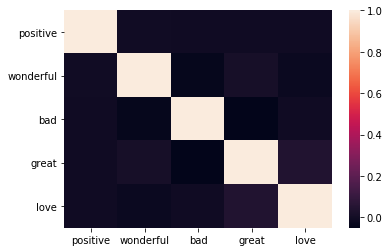

In [17]:
sns.heatmap(reviews.corr())
plt.show()

In [18]:
data = reviews[keywords]
target = reviews['positive']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 1
